In [ ]:
import torch
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from warnings import filterwarnings

df = sns.load_dataset("titanic")


df = df.drop(columns=["deck", "embark_town", "alive", "class", "who", "adult_male", "alone"])


df["age"].fillna(df["age"].median(), inplace=True)
df["embarked"].fillna(df["embarked"].mode()[0], inplace=True)


label_encoders = {}
for col in ["sex", "embarked"]:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df.drop(columns=["survived"])
y = df["survived"]

# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train.values, dtype=torch.long)  # Integer labels for classification
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test.values, dtype=torch.long)

C:\Users\Zainch-032\AppData\Local\Temp\ipykernel_15288\3104681935.py:18: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["age"].fillna(df["age"].median(), inplace=True)
C:\Users\Zainch-032\AppData\Local\Temp\ipykernel_15288\3104681935.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a 

##### Defining the classess 
##### Relu for non -linearity
##### Softmax for output layer
##### Loss entropy 

In [9]:
class RegressionNN:
    def __init__(self, n_inputs, n_neurons):
        self.weights = torch.randn(n_inputs, n_neurons, requires_grad=True) * 0.01
        self.biases = torch.zeros(1, n_neurons, requires_grad=True)

    def forward(self, inputs):
        self.inputs = inputs
        self.output = torch.matmul(inputs, self.weights) + self.biases

    def backward(self, dvalues):
        # Gradients for weights, biases, and inputs
        self.dweights = torch.matmul(self.inputs.T, dvalues)
        self.dbiases = torch.sum(dvalues, axis=0, keepdim=True)
        self.dinputs = torch.matmul(dvalues, self.weights.T)

class ActivationReLU:
    def forward(self, inputs):
        self.inputs = inputs
        self.output = torch.maximum(inputs, torch.zeros_like(inputs))

    def backward(self, dvalues):
        # Gradient of ReLU
        self.dinputs = dvalues.clone()
        self.dinputs[self.inputs <= 0] = 0

class ActivationSoftmax:
    def forward(self, inputs):
        exp_vals = torch.exp(inputs - torch.max(inputs, dim=1, keepdim=True).values)
        probabilities = exp_vals / torch.sum(exp_vals, dim=1, keepdim=True)
        self.output = probabilities

class LossCategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        y_pred_clip = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 2:
            correct_confidences = torch.sum(y_pred_clip * y_true, dim=1)
        else:
            correct_confidences = y_pred_clip[range(len(y_pred)), y_true]
        negative_log_likelihoods = -torch.log(correct_confidences)
        return negative_log_likelihoods

    def calculate(self, y_pred, y_true):
        sample_losses = self.forward(y_pred, y_true)
        data_loss = torch.mean(sample_losses)
        return data_loss

    def backward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clip = torch.clamp(y_pred, 1e-7, 1 - 1e-7)
        if len(y_true.shape) == 2:
            self.dinputs = -y_true / y_pred_clip
        else:
            self.dinputs = torch.zeros_like(y_pred_clip)
            self.dinputs[range(samples), y_true] = -1 / y_pred_clip[range(samples), y_true]
        self.dinputs = self.dinputs / samples


In [10]:
class ClassificationNN:
    def __init__(self, n_inputs, n_neurons, n_outputs):
        
        self.layer1 = RegressionNN(n_inputs, n_neurons)
        self.activation1 = ActivationReLU()

       
        self.layer2 = RegressionNN(n_neurons, 128)
        self.activation2 = ActivationReLU()

        self.layer3 = RegressionNN(128, n_outputs)
        self.activation3 = ActivationSoftmax()

    def forward(self, inputs):
        self.layer1.forward(inputs)
        self.activation1.forward(self.layer1.output)
        self.layer2.forward(self.activation1.output)
        self.activation2.forward(self.layer2.output)
        self.layer3.forward(self.activation2.output)
        self.activation3.forward(self.layer3.output)
        self.output = self.activation3.output

    def backward(self, dvalues):
        # Backpropagate through all layers
        self.activation3.dinputs = dvalues  
        self.layer3.backward(self.activation3.dinputs)

        self.activation2.backward(self.layer3.dinputs)
        self.layer2.backward(self.activation2.dinputs)

        self.activation1.backward(self.layer2.dinputs)
        self.layer1.backward(self.activation1.dinputs)

n_features = X_train.shape[1]
n_classes = len(np.unique(y))
model = ClassificationNN(n_features, 256, n_classes)  

loss_function = LossCategoricalCrossentropy()
learning_rate = 0.001
epochs = 30

# Lists to store the loss and accuracy for plotting
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []


for epoch in range(epochs):
    # Forward pass
    model.forward(X_train)
    loss = loss_function.calculate(model.output, y_train)
    train_losses.append(loss.item())

    # Calculate accuracy for training
    predictions = torch.argmax(model.output, axis=1)
    train_accuracy = torch.mean((predictions == y_train).float()).item()
    train_accuracies.append(train_accuracy)

    loss_function.backward(model.output, y_train)  
    model.backward(loss_function.dinputs)  

    # Update weights and biases manually
    with torch.no_grad():
        model.layer1.weights -= learning_rate * model.layer1.dweights
        model.layer1.biases -= learning_rate * model.layer1.dbiases
        model.layer2.weights -= learning_rate * model.layer2.dweights
        model.layer2.biases -= learning_rate * model.layer2.dbiases
        model.layer3.weights -= learning_rate * model.layer3.dweights
        model.layer3.biases -= learning_rate * model.layer3.dbiases

    # Validation
    model.forward(X_test)
    test_loss = loss_function.calculate(model.output, y_test)
    test_losses.append(test_loss.item())

    
    test_predictions = torch.argmax(model.output, axis=1)
    test_accuracy = torch.mean((test_predictions == y_test).float()).item()
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {loss:.4f}, Test Loss: {test_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Evaluate performance metrics
model.forward(X_test)
test_predictions = torch.argmax(model.output, axis=1)



Epoch 1/30, Train Loss: 0.6931, Test Loss: 0.6931, Train Accuracy: 0.7107, Test Accuracy: 0.5698
Epoch 2/30, Train Loss: 0.6931, Test Loss: 0.6930, Train Accuracy: 0.6222, Test Accuracy: 0.5866
Epoch 3/30, Train Loss: 0.6930, Test Loss: 0.6930, Train Accuracy: 0.6208, Test Accuracy: 0.5866
Epoch 4/30, Train Loss: 0.6929, Test Loss: 0.6929, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 5/30, Train Loss: 0.6929, Test Loss: 0.6929, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 6/30, Train Loss: 0.6928, Test Loss: 0.6929, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 7/30, Train Loss: 0.6927, Test Loss: 0.6928, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 8/30, Train Loss: 0.6927, Test Loss: 0.6928, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 9/30, Train Loss: 0.6926, Test Loss: 0.6927, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 10/30, Train Loss: 0.6926, Test Loss: 0.6927, Train Accuracy: 0.6236, Test Accuracy: 0.5866
Epoch 11/30, Train Loss: 0.69

##### Plotting for visualizing


Test Accuracy: 0.5866
Test Precision: 0.2933
Test Recall: 0.5000
Test F1 Score: 0.3697


c:\Users\Zainch-032\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


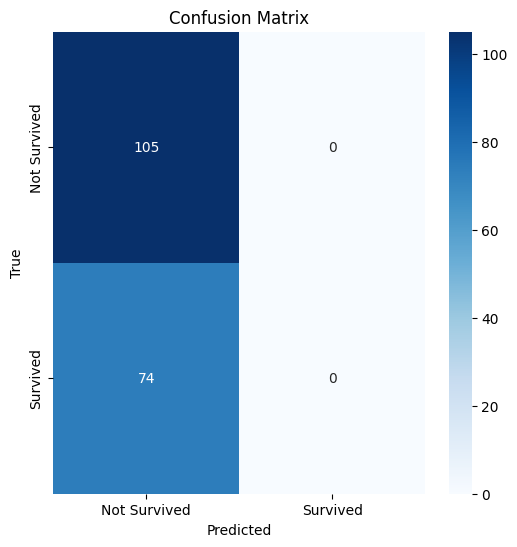

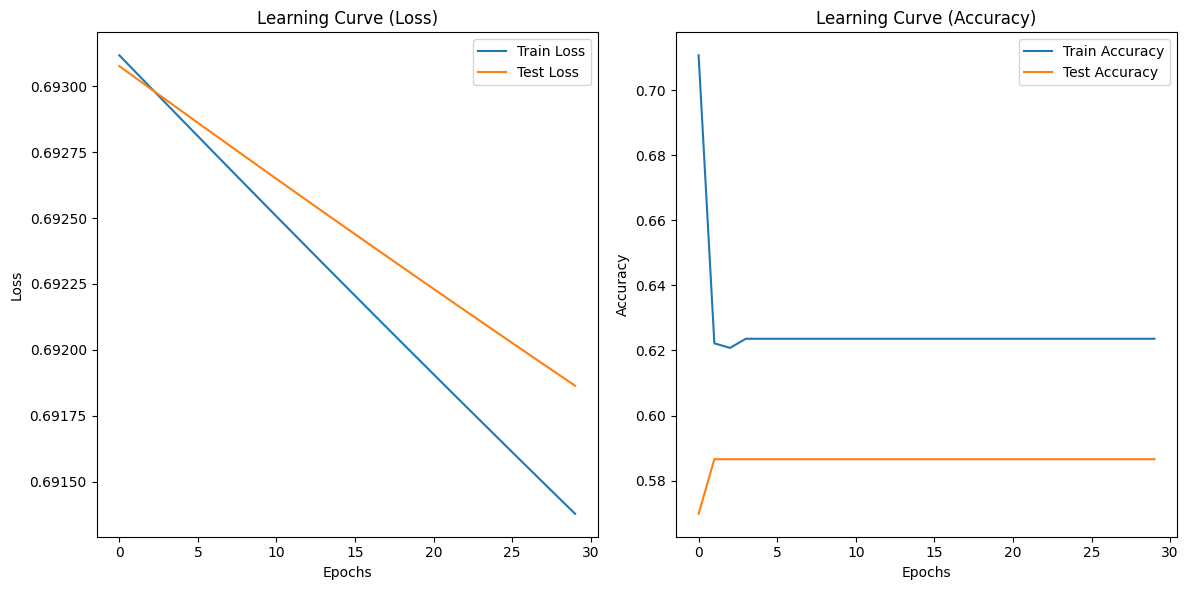

In [11]:
# Calculate metrics
accuracy = accuracy_score(y_test, test_predictions)
precision = precision_score(y_test, test_predictions, average='macro')
recall = recall_score(y_test, test_predictions, average='macro')
f1 = f1_score(y_test, test_predictions, average='macro')

print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Precision: {precision:.4f}")
print(f"Test Recall: {recall:.4f}")
print(f"Test F1 Score: {f1:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, test_predictions)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Survived", "Survived"], yticklabels=["Not Survived", "Survived"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Plotting learning curves
plt.figure(figsize=(12, 6))

# Plot Loss
plt.subplot(1, 2, 1)
plt.plot(range(epochs), train_losses, label='Train Loss')
plt.plot(range(epochs), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Learning Curve (Loss)')

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.plot(range(epochs), train_accuracies, label='Train Accuracy')
plt.plot(range(epochs), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Learning Curve (Accuracy)')

plt.tight_layout()
plt.show()
